In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
#from SpykeTorch import makeInput
#import cifar10

import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [2]:
rf_size = 28 # Receptive field size that will be provided as input to the column
num_neurons = rf_size*rf_size # Number of excitatory neurons in the column
startposition = 0 # Start position of the receptive field w.r.t. top left corner of image
threshold = 75 # Firing threshold for every excitatory neuron
timesteps = 8 # Resolution for timesteps and weights

In [3]:
class PreProcTransform:
    def __init__(self, filter, timesteps = timesteps):
        self.to_tensor = transforms.ToTensor() # Convert to tensor
        self.filter = filter # Apply OnOff filtering
        self.temporal_transform = utils.Intensity2Latency(timesteps) # Convert pixel values to time
                                                    # Higher value corresponds to earlier spiketime
        self.crop = utils.Crop(startposition, rf_size) # Crop the image to form the receptive field
        
    def __call__(self, image):
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0) # Adds a temporal dimension at the beginning
        image = self.filter(image)
        temporal_image = self.temporal_transform(image)
        temporal_image = temporal_image.sign() # This will create spikes
        return self.crop(temporal_image)
    
kernels = [utils.OnKernel(3), utils.OffKernel(3)]
inchannels = len(kernels)

filter = utils.Filter(kernels, padding = 2, thresholds = 50)
preproc = PreProcTransform(filter)

In [4]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = preproc))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = preproc))
MNIST_trainLoader = DataLoader(MNIST_train, batch_size=1000, shuffle=True)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1000, shuffle=True)

In [5]:
class Column(nn.Module):
    def __init__(self):
        super(Column, self).__init__()
        # Local Convolution layer which creates columns with unique weights (NOT shared weights). The
        # number of columns is based on input_size, kernel_size and stride. Here since we are simulating
        # only one column, the input_size and kernel_size are kept same.
        self.ec = snn.HopfieldNetwork()
        # STDP module which implements the given STDP rule for the above layer (a single column in this case)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)
        
    def forward(self, rec_field):
        ### Start of Excitatory Column ###
        out = self.ec(rec_field)
        #spike, pot = sf.fire(out, threshold, True)
        ### End of Excitatory Column ###
        ### Start of Lateral Inhibition ###
        #out = sf.pointwise_inhibition(pot).sign()
        ### End of Lateral Inhibition ###
        return out

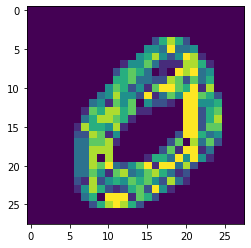

In [6]:
MyColumn=Column()
train_pattern=[torch.sum(torch.sum(MNIST_train[1][0],dim=0),dim=0)]#,torch.sum(torch.sum(MNIST_train[2][0],dim=0),dim=0)]#[torch.tensor([7,0,0,0,0,7,0,0,0,0,7,0,0,0,0,7]).type(torch.FloatTensor).reshape(4,4)]
MyColumn.ec.train_weights(train_pattern)#[torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4)])#[torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
plt.imshow(train_pattern[0])#torch.tensor([0,1,2,3,4,5,6,7]*2).reshape(4,4))#torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))
#MyColumn.ec.train_weights([torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0)])
#plt.imshow(torch.sum(torch.sum(MNIST_train[0][0],dim=0),dim=0))

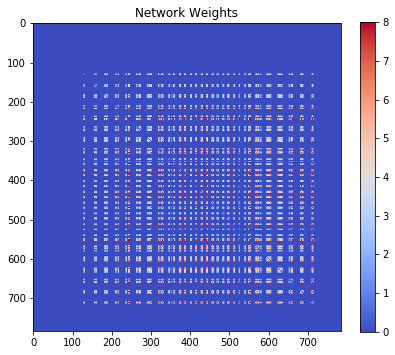

In [7]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(MyColumn.ec.W, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.savefig("weights.png")
plt.show()

In [8]:
pattern=torch.sum(MNIST_train[1][0],dim=1).reshape(8,784)#torch.tensor([0]*784).type(torch.FloatTensor)#torch.tensor([2,6,3,1,7,4,5,2,7,7,7,7,3,7,5,5]).type(torch.FloatTensor)#(torch.tensor([0,1,2,3,4,5,6,7]*2).type(torch.FloatTensor))#torch.sum(torch.sum(MNIST_train[1][0],dim=0),dim=0).reshape(784)-4)/4
out=MyColumn.ec.forward([pattern.clone()],threshold=100,num_iter=20)
print(out.size())

tensor(341)
tensor(53)
tensor(78)
tensor(697)
tensor(607)
tensor(398)
tensor(605)
tensor(31)
tensor(324)
tensor(277)
tensor(204)
tensor(370)
tensor(181)
tensor(13)
tensor(54)
tensor(642)
tensor(170)
tensor(66)
tensor(619)
tensor(578)
tensor(521)
tensor(700)
tensor(224)
tensor(732)
tensor(751)
tensor(452)
tensor(72)
tensor(609)
tensor(159)
tensor(491)
tensor(18)
tensor(739)
tensor(566)
tensor(102)
tensor(550)
tensor(492)
tensor(576)
tensor(177)
tensor(153)
tensor(750)
tensor(302)
tensor(424)
tensor(48)
tensor(480)
tensor(705)
tensor(754)
tensor(51)
tensor(612)
tensor(106)
tensor(197)
tensor(759)
tensor(780)
tensor(50)
tensor(573)
tensor(377)
tensor(498)
tensor(552)
tensor(297)
tensor(248)
tensor(510)
tensor(114)
tensor(457)
tensor(669)
tensor(543)
tensor(755)
tensor(666)
tensor(660)
tensor(408)
tensor(325)
tensor(768)
tensor(266)
tensor(25)
tensor(778)
tensor(362)
tensor(586)
tensor(425)
tensor(723)
tensor(508)
tensor(175)
tensor(21)
tensor(287)
tensor(503)
tensor(668)
tensor(339)
tenso

tensor(384)
tensor(727)
tensor(134)
tensor(85)
tensor(783)
tensor(28)
tensor(118)
tensor(318)
tensor(608)
tensor(396)
tensor(763)
tensor(707)
tensor(433)
tensor(215)
tensor(65)
tensor(367)
tensor(378)
tensor(606)
tensor(107)
tensor(265)
tensor(225)
tensor(753)
tensor(279)
tensor(708)
tensor(542)
tensor(36)
tensor(126)
tensor(581)
tensor(487)
tensor(271)
tensor(173)
tensor(472)
tensor(617)
tensor(158)
tensor(471)
tensor(142)
tensor(120)
tensor(252)
tensor(39)
tensor(691)
tensor(233)
tensor(597)
tensor(505)
tensor(272)
tensor(782)
tensor(625)
tensor(182)
tensor(448)
tensor(312)
tensor(334)
tensor(75)
tensor(773)
tensor(73)
tensor(261)
tensor(387)
tensor(223)
tensor(529)
tensor(17)
tensor(525)
tensor(699)
tensor(455)
tensor(207)
tensor(527)
tensor(86)
tensor(402)
tensor(322)
tensor(465)
tensor(752)
tensor(198)
tensor(476)
tensor(564)
tensor(296)
tensor(90)
tensor(40)
tensor(633)
tensor(644)
tensor(570)
tensor(604)
tensor(316)
tensor(575)
tensor(133)
tensor(540)
tensor(501)
tensor(284)
ten

tensor(621)
tensor(213)
tensor(384)
tensor(500)
tensor(466)
tensor(266)
tensor(313)
tensor(192)
tensor(126)
tensor(19)
tensor(704)
tensor(589)
tensor(77)
tensor(108)
tensor(503)
tensor(293)
tensor(754)
tensor(775)
tensor(80)
tensor(603)
tensor(164)
tensor(236)
tensor(512)
tensor(54)
tensor(479)
tensor(694)
tensor(97)
tensor(574)
tensor(681)
tensor(168)
tensor(712)
tensor(504)
tensor(780)
tensor(637)
tensor(134)
tensor(609)
tensor(316)
tensor(752)
tensor(456)
tensor(124)
tensor(427)
tensor(708)
tensor(743)
tensor(214)
tensor(107)
tensor(569)
tensor(114)
tensor(280)
tensor(119)
tensor(499)
tensor(587)
tensor(778)
tensor(262)
tensor(116)
tensor(24)
tensor(377)
tensor(581)
tensor(52)
tensor(260)
tensor(395)
tensor(736)
tensor(421)
tensor(248)
tensor(175)
tensor(258)
tensor(394)
tensor(546)
tensor(276)
tensor(59)
tensor(147)
tensor(645)
tensor(564)
tensor(208)
tensor(298)
tensor(761)
tensor(318)
tensor(656)
tensor(415)
tensor(767)
tensor(732)
tensor(441)
tensor(63)
tensor(198)
tensor(212)
t

tensor(339)
tensor(20)
tensor(166)
tensor(599)
tensor(761)
tensor(489)
tensor(177)
tensor(191)
tensor(366)
tensor(40)
tensor(261)
tensor(215)
tensor(614)
tensor(408)
tensor(101)
tensor(59)
tensor(209)
tensor(161)
tensor(113)
tensor(115)
tensor(432)
tensor(401)
tensor(430)
tensor(429)
tensor(376)
tensor(24)
tensor(167)
tensor(232)
tensor(53)
tensor(125)
tensor(98)
tensor(657)
tensor(533)
tensor(638)
tensor(347)
tensor(620)
tensor(210)
tensor(419)
tensor(129)
tensor(107)
tensor(515)
tensor(668)
tensor(109)
tensor(542)
tensor(636)
tensor(100)
tensor(448)
tensor(17)
tensor(774)
tensor(330)
tensor(592)
tensor(611)
tensor(375)
tensor(557)
tensor(438)
tensor(41)
tensor(494)
tensor(300)
tensor(374)
tensor(679)
tensor(670)
tensor(719)
tensor(564)
tensor(389)
tensor(686)
tensor(272)
tensor(583)
tensor(628)
tensor(253)
tensor(149)
tensor(763)
tensor(653)
tensor(402)
tensor(517)
tensor(588)
tensor(676)
tensor(585)
tensor(203)
tensor(276)
tensor(498)
tensor(316)
tensor(296)
tensor(110)
tensor(666)


tensor(77)
tensor(138)
tensor(723)
tensor(386)
tensor(465)
tensor(380)
tensor(460)
tensor(124)
tensor(346)
tensor(510)
tensor(150)
tensor(5)
tensor(373)
tensor(202)
tensor(31)
tensor(59)
tensor(451)
tensor(165)
tensor(692)
tensor(731)
tensor(671)
tensor(213)
tensor(234)
tensor(97)
tensor(439)
tensor(665)
tensor(126)
tensor(446)
tensor(734)
tensor(409)
tensor(363)
tensor(333)
tensor(416)
tensor(552)
tensor(606)
tensor(550)
tensor(660)
tensor(565)
tensor(411)
tensor(159)
tensor(768)
tensor(719)
tensor(184)
tensor(717)
tensor(303)
tensor(8)
tensor(600)
tensor(687)
tensor(29)
tensor(581)
tensor(482)
tensor(168)
tensor(326)
tensor(753)
tensor(613)
tensor(560)
tensor(437)
tensor(157)
tensor(314)
tensor(697)
tensor(672)
tensor(262)
tensor(155)
tensor(163)
tensor(2)
tensor(364)
tensor(355)
tensor(58)
tensor(624)
tensor(627)
tensor(203)
tensor(12)
tensor(706)
tensor(566)
tensor(369)
tensor(38)
tensor(393)
tensor(548)
tensor(391)
tensor(293)
tensor(708)
tensor(247)
tensor(110)
tensor(347)
tensor

tensor(308)
tensor(707)
tensor(223)
tensor(752)
tensor(264)
tensor(75)
tensor(217)
tensor(466)
tensor(457)
tensor(240)
tensor(138)
tensor(168)
tensor(529)
tensor(318)
tensor(97)
tensor(40)
tensor(428)
tensor(578)
tensor(114)
tensor(769)
tensor(655)
tensor(2)
tensor(361)
tensor(220)
tensor(744)
tensor(681)
tensor(660)
tensor(1)
tensor(26)
tensor(629)
tensor(782)
tensor(620)
tensor(570)
tensor(692)
tensor(68)
tensor(417)
tensor(605)
tensor(505)
tensor(256)
tensor(618)
tensor(779)
tensor(718)
tensor(538)
tensor(314)
tensor(145)
tensor(219)
tensor(552)
tensor(251)
tensor(549)
tensor(396)
tensor(636)
tensor(422)
tensor(405)
tensor(477)
tensor(203)
tensor(390)
tensor(263)
tensor(690)
tensor(575)
tensor(756)
tensor(290)
tensor(100)
tensor(144)
tensor(330)
tensor(214)
tensor(467)
tensor(506)
tensor(588)
tensor(360)
tensor(714)
tensor(454)
tensor(419)
tensor(561)
tensor(182)
tensor(208)
tensor(748)
tensor(469)
tensor(255)
tensor(342)
tensor(651)
tensor(571)
tensor(471)
tensor(460)
tensor(424)
t

tensor(123)
tensor(332)
tensor(577)
tensor(341)
tensor(657)
tensor(735)
tensor(207)
tensor(589)
tensor(32)
tensor(60)
tensor(722)
tensor(481)
tensor(19)
tensor(30)
tensor(42)
tensor(283)
tensor(266)
tensor(658)
tensor(281)
tensor(22)
tensor(651)
tensor(20)
tensor(44)
tensor(736)
tensor(681)
tensor(385)
tensor(154)
tensor(728)
tensor(616)
tensor(210)
tensor(487)
tensor(489)
tensor(329)
tensor(774)
tensor(723)
tensor(528)
tensor(648)
tensor(490)
tensor(468)
tensor(388)
tensor(555)
tensor(308)
tensor(436)
tensor(778)
tensor(434)
tensor(504)
tensor(720)
tensor(398)
tensor(33)
tensor(159)
tensor(691)
tensor(667)
tensor(296)
tensor(586)
tensor(568)
tensor(50)
tensor(130)
tensor(684)
tensor(80)
tensor(656)
tensor(459)
tensor(47)
tensor(414)
tensor(604)
tensor(493)
tensor(156)
tensor(549)
tensor(134)
tensor(411)
tensor(39)
tensor(668)
tensor(495)
tensor(358)
tensor(573)
tensor(465)
tensor(439)
tensor(293)
tensor(120)
tensor(24)
tensor(361)
tensor(203)
tensor(570)
tensor(306)
tensor(441)
tensor

tensor(281)
tensor(347)
tensor(327)
tensor(203)
tensor(37)
tensor(67)
tensor(95)
tensor(130)
tensor(748)
tensor(171)
tensor(497)
tensor(317)
tensor(363)
tensor(783)
tensor(172)
tensor(451)
tensor(485)
tensor(710)
tensor(636)
tensor(47)
tensor(682)
tensor(5)
tensor(16)
tensor(696)
tensor(499)
tensor(18)
tensor(585)
tensor(57)
tensor(643)
tensor(28)
tensor(49)
tensor(574)
tensor(610)
tensor(704)
tensor(644)
tensor(29)
tensor(480)
tensor(578)
tensor(725)
tensor(17)
tensor(735)
tensor(90)
tensor(266)
tensor(233)
tensor(729)
tensor(173)
tensor(263)
tensor(65)
tensor(177)
tensor(188)
tensor(510)
tensor(45)
tensor(720)
tensor(661)
tensor(218)
tensor(99)
tensor(25)
tensor(634)
tensor(309)
tensor(580)
tensor(26)
tensor(779)
tensor(680)
tensor(209)
tensor(482)
tensor(287)
tensor(165)
tensor(455)
tensor(708)
tensor(3)
tensor(579)
tensor(718)
tensor(213)
tensor(408)
tensor(414)
tensor(219)
tensor(38)
tensor(684)
tensor(731)
tensor(0)
tensor(104)
tensor(271)
tensor(543)
tensor(548)
tensor(703)
tens

tensor(439)
tensor(668)
tensor(11)
tensor(483)
tensor(254)
tensor(46)
tensor(534)
tensor(673)
tensor(526)
tensor(412)
tensor(94)
tensor(146)
tensor(464)
tensor(566)
tensor(95)
tensor(757)
tensor(309)
tensor(345)
tensor(198)
tensor(507)
tensor(567)
tensor(341)
tensor(532)
tensor(500)
tensor(130)
tensor(247)
tensor(8)
tensor(163)
tensor(356)
tensor(643)
tensor(225)
tensor(171)
tensor(558)
tensor(726)
tensor(605)
tensor(40)
tensor(655)
tensor(199)
tensor(262)
tensor(297)
tensor(269)
tensor(353)
tensor(169)
tensor(775)
tensor(205)
tensor(618)
tensor(725)
tensor(33)
tensor(2)
tensor(653)
tensor(100)
tensor(609)
tensor(187)
tensor(451)
tensor(108)
tensor(478)
tensor(249)
tensor(190)
tensor(637)
tensor(5)
tensor(495)
tensor(238)
tensor(217)
tensor(689)
tensor(279)
tensor(429)
tensor(723)
tensor(86)
tensor(633)
tensor(681)
tensor(0)
tensor(194)
tensor(19)
tensor(704)
tensor(184)
tensor(237)
tensor(390)
tensor(776)
tensor(6)
tensor(552)
tensor(447)
tensor(530)
tensor(491)
tensor(650)
tensor(523

tensor(388)
tensor(212)
tensor(35)
tensor(423)
tensor(664)
tensor(753)
tensor(535)
tensor(525)
tensor(577)
tensor(424)
tensor(144)
tensor(227)
tensor(17)
tensor(160)
tensor(509)
tensor(105)
tensor(544)
tensor(47)
tensor(150)
tensor(445)
tensor(683)
tensor(652)
tensor(779)
tensor(436)
tensor(116)
tensor(563)
tensor(386)
tensor(597)
tensor(84)
tensor(695)
tensor(413)
tensor(296)
tensor(48)
tensor(77)
tensor(23)
tensor(75)
tensor(485)
tensor(396)
tensor(204)
tensor(639)
tensor(674)
tensor(606)
tensor(285)
tensor(253)
tensor(418)
tensor(587)
tensor(327)
tensor(384)
tensor(102)
tensor(669)
tensor(162)
tensor(230)
tensor(236)
tensor(780)
tensor(728)
tensor(635)
tensor(518)
tensor(767)
tensor(157)
tensor(674)
tensor(593)
tensor(43)
tensor(694)
tensor(143)
tensor(470)
tensor(268)
tensor(499)
tensor(225)
tensor(571)
tensor(660)
tensor(782)
tensor(574)
tensor(0)
tensor(118)
tensor(745)
tensor(780)
tensor(732)
tensor(285)
tensor(149)
tensor(666)
tensor(406)
tensor(146)
tensor(566)
tensor(368)
ten

tensor(583)
tensor(556)
tensor(202)
tensor(121)
tensor(297)
tensor(699)
tensor(49)
tensor(692)
tensor(229)
tensor(487)
tensor(486)
tensor(240)
tensor(447)
tensor(599)
tensor(107)
tensor(442)
tensor(547)
tensor(350)
tensor(664)
tensor(482)
tensor(10)
tensor(34)
tensor(59)
tensor(147)
tensor(222)
tensor(772)
tensor(157)
tensor(500)
tensor(110)
tensor(598)
tensor(630)
tensor(37)
tensor(162)
tensor(30)
tensor(38)
tensor(450)
tensor(626)
tensor(640)
tensor(54)
tensor(472)
tensor(275)
tensor(462)
tensor(325)
tensor(48)
tensor(334)
tensor(20)
tensor(65)
tensor(697)
tensor(208)
tensor(266)
tensor(420)
tensor(359)
tensor(365)
tensor(548)
tensor(440)
tensor(425)
tensor(302)
tensor(415)
tensor(156)
tensor(722)
tensor(51)
tensor(211)
tensor(132)
tensor(542)
tensor(86)
tensor(378)
tensor(277)
tensor(99)
tensor(413)
tensor(264)
tensor(123)
tensor(186)
tensor(320)
tensor(148)
tensor(706)
tensor(387)
tensor(182)
tensor(161)
tensor(294)
tensor(254)
tensor(783)
tensor(66)
tensor(4)
tensor(344)
tensor(60

tensor(496)
tensor(705)
tensor(182)
tensor(647)
tensor(23)
tensor(156)
tensor(539)
tensor(145)
tensor(691)
tensor(548)
tensor(578)
tensor(173)
tensor(21)
tensor(617)
tensor(239)
tensor(662)
tensor(637)
tensor(222)
tensor(678)
tensor(271)
tensor(86)
tensor(207)
tensor(139)
tensor(129)
tensor(27)
tensor(419)
tensor(740)
tensor(106)
tensor(498)
tensor(373)
tensor(186)
tensor(360)
tensor(639)
tensor(228)
tensor(13)
tensor(317)
tensor(417)
tensor(227)
tensor(596)
tensor(501)
tensor(74)
tensor(564)
tensor(223)
tensor(690)
tensor(175)
tensor(590)
tensor(426)
tensor(369)
tensor(11)
tensor(710)
tensor(761)
tensor(218)
tensor(75)
tensor(117)
tensor(256)
tensor(475)
tensor(219)
tensor(436)
tensor(37)
tensor(53)
tensor(365)
tensor(272)
tensor(289)
tensor(653)
tensor(715)
tensor(753)
tensor(252)
tensor(588)
tensor(81)
tensor(196)
tensor(670)
tensor(268)
tensor(162)
tensor(567)
tensor(684)
tensor(168)
tensor(409)
tensor(585)
tensor(757)
tensor(470)
tensor(107)
tensor(556)
tensor(320)
tensor(370)
ten

tensor(323)
tensor(91)
tensor(225)
tensor(440)
tensor(463)
tensor(675)
tensor(631)
tensor(394)
tensor(308)
tensor(224)
tensor(190)
tensor(783)
tensor(517)
tensor(90)
tensor(200)
tensor(467)
tensor(55)
tensor(186)
tensor(154)
tensor(664)
tensor(649)
tensor(248)
tensor(281)
tensor(425)
tensor(583)
tensor(453)
tensor(544)
tensor(60)
tensor(656)
tensor(563)
tensor(160)
tensor(230)
tensor(24)
tensor(622)
tensor(706)
tensor(315)
tensor(287)
tensor(10)
tensor(282)
tensor(620)
tensor(684)
tensor(68)
tensor(522)
tensor(179)
tensor(106)
tensor(23)
tensor(686)
tensor(346)
tensor(146)
tensor(50)
tensor(651)
tensor(138)
tensor(780)
tensor(601)
tensor(615)
tensor(257)
tensor(284)
tensor(680)
tensor(629)
tensor(156)
tensor(383)
tensor(343)
tensor(161)
tensor(256)
tensor(375)
tensor(673)
tensor(347)
tensor(201)
tensor(448)
tensor(445)
tensor(438)
tensor(771)
tensor(180)
tensor(62)
tensor(53)
tensor(12)
tensor(104)
tensor(103)
tensor(122)
tensor(710)
tensor(236)
tensor(31)
tensor(595)
tensor(648)
tenso

tensor(378)
tensor(110)
tensor(323)
tensor(535)
tensor(572)
tensor(47)
tensor(140)
tensor(358)
tensor(354)
tensor(17)
tensor(452)
tensor(297)
tensor(365)
tensor(450)
tensor(757)
tensor(771)
tensor(698)
tensor(615)
tensor(347)
tensor(212)
tensor(285)
tensor(14)
tensor(674)
tensor(95)
tensor(521)
tensor(445)
tensor(85)
tensor(539)
tensor(264)
tensor(440)
tensor(494)
tensor(77)
tensor(725)
tensor(64)
tensor(555)
tensor(403)
tensor(395)
tensor(623)
tensor(12)
tensor(714)
tensor(135)
tensor(415)
tensor(766)
tensor(69)
tensor(58)
tensor(9)
tensor(508)
tensor(166)
tensor(402)
tensor(626)
tensor(661)
tensor(466)
tensor(394)
tensor(576)
tensor(526)
tensor(780)
tensor(593)
tensor(705)
tensor(156)
tensor(8)
tensor(422)
tensor(119)
tensor(245)
tensor(362)
tensor(547)
tensor(273)
tensor(142)
tensor(357)
tensor(719)
tensor(260)
tensor(150)
tensor(752)
tensor(686)
tensor(677)
tensor(220)
tensor(139)
tensor(20)
tensor(428)
tensor(406)
tensor(442)
tensor(280)
tensor(333)
tensor(739)
tensor(134)
tensor(

tensor(554)
tensor(770)
tensor(486)
tensor(461)
tensor(423)
tensor(487)
tensor(85)
tensor(472)
tensor(247)
tensor(172)
tensor(759)
tensor(629)
tensor(489)
tensor(718)
tensor(539)
tensor(166)
tensor(705)
tensor(512)
tensor(648)
tensor(684)
tensor(762)
tensor(98)
tensor(758)
tensor(650)
tensor(304)
tensor(117)
tensor(638)
tensor(228)
tensor(174)
tensor(690)
tensor(473)
tensor(577)
tensor(101)
tensor(221)
tensor(248)
tensor(754)
tensor(293)
tensor(480)
tensor(559)
tensor(209)
tensor(505)
tensor(641)
tensor(419)
tensor(761)
tensor(760)
tensor(688)
tensor(182)
tensor(661)
tensor(75)
tensor(698)
tensor(645)
tensor(697)
tensor(28)
tensor(163)
tensor(121)
tensor(458)
tensor(30)
tensor(11)
tensor(731)
tensor(106)
tensor(258)
tensor(497)
tensor(424)
tensor(728)
tensor(430)
tensor(479)
tensor(414)
tensor(34)
tensor(73)
tensor(222)
tensor(43)
tensor(606)
tensor(477)
tensor(720)
tensor(138)
tensor(712)
tensor(70)
tensor(733)
tensor(462)
tensor(723)
tensor(343)
tensor(10)
tensor(196)
tensor(333)
ten

tensor(537)
tensor(508)
tensor(314)
tensor(320)
tensor(88)
tensor(760)
tensor(76)
tensor(104)
tensor(658)
tensor(125)
tensor(51)
tensor(279)
tensor(580)
tensor(32)
tensor(771)
tensor(719)
tensor(340)
tensor(717)
tensor(257)
tensor(128)
tensor(608)
tensor(545)
tensor(44)
tensor(262)
tensor(395)
tensor(625)
tensor(716)
tensor(152)
tensor(582)
tensor(401)
tensor(270)
tensor(26)
tensor(110)
tensor(588)
tensor(767)
tensor(737)
tensor(467)
tensor(192)
tensor(474)
tensor(504)
tensor(438)
tensor(458)
tensor(380)
tensor(618)
tensor(111)
tensor(70)
tensor(633)
tensor(631)
tensor(139)
tensor(546)
tensor(211)
tensor(142)
tensor(539)
tensor(183)
tensor(485)
tensor(272)
tensor(522)
tensor(585)
tensor(235)
tensor(86)
tensor(253)
tensor(490)
tensor(282)
tensor(12)
tensor(27)
tensor(496)
tensor(368)
tensor(345)
tensor(61)
tensor(757)
tensor(406)
tensor(10)
tensor(679)
tensor(108)
tensor(525)
tensor(685)
tensor(675)
tensor(770)
tensor(24)
tensor(229)
tensor(464)
tensor(502)
tensor(87)
tensor(278)
tensor

tensor(770)
tensor(142)
tensor(689)
tensor(559)
tensor(648)
tensor(505)
tensor(235)
tensor(70)
tensor(574)
tensor(663)
tensor(157)
tensor(448)
tensor(780)
tensor(717)
tensor(121)
tensor(610)
tensor(358)
tensor(38)
tensor(15)
tensor(132)
tensor(361)
tensor(412)
tensor(248)
tensor(685)
tensor(651)
tensor(7)
tensor(495)
tensor(725)
tensor(347)
tensor(249)
tensor(152)
tensor(607)
tensor(602)
tensor(110)
tensor(487)
tensor(687)
tensor(213)
tensor(285)
tensor(289)
tensor(182)
tensor(238)
tensor(451)
tensor(447)
tensor(478)
tensor(18)
tensor(53)
tensor(367)
tensor(108)
tensor(413)
tensor(704)
tensor(376)
tensor(355)
tensor(51)
tensor(491)
tensor(581)
tensor(149)
tensor(584)
tensor(131)
tensor(719)
tensor(446)
tensor(194)
tensor(329)
tensor(598)
tensor(716)
tensor(530)
tensor(422)
tensor(283)
tensor(606)
tensor(435)
tensor(438)
tensor(753)
tensor(533)
tensor(393)
tensor(714)
tensor(774)
tensor(171)
tensor(389)
tensor(150)
tensor(673)
tensor(231)
tensor(401)
tensor(735)
tensor(343)
tensor(165)


tensor(747)
tensor(524)
tensor(566)
tensor(693)
tensor(682)
tensor(475)
tensor(542)
tensor(293)
tensor(382)
tensor(688)
tensor(657)
tensor(306)
tensor(506)
tensor(36)
tensor(125)
tensor(73)
tensor(64)
tensor(147)
tensor(123)
tensor(48)
tensor(668)
tensor(504)
tensor(589)
tensor(755)
tensor(360)
tensor(446)
tensor(640)
tensor(347)
tensor(334)
tensor(118)
tensor(732)
tensor(447)
tensor(107)
tensor(443)
tensor(581)
tensor(482)
tensor(132)
tensor(129)
tensor(723)
tensor(594)
tensor(224)
tensor(198)
tensor(406)
tensor(623)
tensor(167)
tensor(242)
tensor(491)
tensor(294)
tensor(140)
tensor(368)
tensor(741)
tensor(367)
tensor(34)
tensor(271)
tensor(484)
tensor(308)
tensor(547)
tensor(278)
tensor(757)
tensor(4)
tensor(203)
tensor(204)
tensor(165)
tensor(206)
tensor(539)
tensor(243)
tensor(341)
tensor(629)
tensor(610)
tensor(146)
tensor(589)
tensor(537)
tensor(777)
tensor(509)
tensor(80)
tensor(767)
tensor(357)
tensor(326)
tensor(489)
tensor(505)
tensor(159)
tensor(488)
tensor(645)
tensor(284)


tensor(678)
tensor(677)
tensor(546)
tensor(109)
tensor(6)
tensor(37)
tensor(0)
tensor(353)
tensor(49)
tensor(436)
tensor(508)
tensor(112)
tensor(538)
tensor(114)
tensor(595)
tensor(148)
tensor(699)
tensor(44)
tensor(262)
tensor(597)
tensor(683)
tensor(774)
tensor(154)
tensor(492)
tensor(213)
tensor(373)
tensor(218)
tensor(429)
tensor(145)
tensor(138)
tensor(101)
tensor(171)
tensor(62)
tensor(197)
tensor(369)
tensor(587)
tensor(246)
tensor(661)
tensor(747)
tensor(158)
tensor(382)
tensor(21)
tensor(147)
tensor(299)
tensor(782)
tensor(663)
tensor(7)
tensor(402)
tensor(717)
tensor(287)
tensor(609)
tensor(121)
tensor(679)
tensor(177)
tensor(134)
tensor(593)
tensor(74)
tensor(622)
tensor(161)
tensor(734)
tensor(229)
tensor(432)
tensor(125)
tensor(627)
tensor(705)
tensor(91)
tensor(632)
tensor(554)
tensor(745)
tensor(50)
tensor(339)
tensor(480)
tensor(338)
tensor(591)
tensor(425)
tensor(291)
tensor(668)
tensor(343)
tensor(511)
tensor(260)
tensor(750)
tensor(208)
tensor(53)
tensor(760)
tensor(

tensor(206)
tensor(669)
tensor(1)
tensor(8)
tensor(727)
tensor(130)
tensor(324)
tensor(730)
tensor(655)
tensor(2)
tensor(574)
tensor(716)
tensor(766)
tensor(39)
tensor(578)
tensor(687)
tensor(774)
tensor(656)
tensor(698)
tensor(355)
tensor(108)
tensor(778)
tensor(457)
tensor(183)
tensor(337)
tensor(96)
tensor(280)
tensor(198)
tensor(105)
tensor(223)
tensor(167)
tensor(249)
tensor(726)
tensor(180)
tensor(401)
tensor(482)
tensor(525)
tensor(284)
tensor(228)
tensor(315)
tensor(587)
tensor(166)
tensor(664)
tensor(256)
tensor(694)
tensor(373)
tensor(776)
tensor(121)
tensor(595)
tensor(588)
tensor(407)
tensor(36)
tensor(679)
tensor(779)
tensor(527)
tensor(211)
tensor(753)
tensor(728)
tensor(432)
tensor(303)
tensor(733)
tensor(160)
tensor(539)
tensor(224)
tensor(624)
tensor(667)
tensor(513)
tensor(476)
tensor(114)
tensor(377)
tensor(782)
tensor(379)
tensor(385)
tensor(767)
tensor(650)
tensor(762)
tensor(699)
tensor(536)
tensor(237)
tensor(663)
tensor(490)
tensor(104)
tensor(748)
tensor(411)
t

tensor(771)
tensor(727)
tensor(254)
tensor(43)
tensor(195)
tensor(398)
tensor(668)
tensor(627)
tensor(54)
tensor(190)
tensor(353)
tensor(256)
tensor(688)
tensor(519)
tensor(157)
tensor(320)
tensor(695)
tensor(122)
tensor(117)
tensor(104)
tensor(325)
tensor(135)
tensor(463)
tensor(110)
tensor(621)
tensor(145)
tensor(625)
tensor(45)
tensor(342)
tensor(705)
tensor(155)
tensor(571)
tensor(328)
tensor(332)
tensor(360)
tensor(131)
tensor(238)
tensor(640)
tensor(83)
tensor(32)
tensor(601)
tensor(301)
tensor(336)
tensor(250)
tensor(652)
tensor(590)
tensor(295)
tensor(563)
tensor(396)
tensor(780)
tensor(760)
tensor(280)
tensor(512)
tensor(526)
tensor(313)
tensor(121)
tensor(28)
tensor(744)
tensor(172)
tensor(50)
tensor(31)
tensor(18)
tensor(620)
tensor(523)
tensor(246)
tensor(66)
tensor(194)
tensor(479)
tensor(501)
tensor(339)
tensor(330)
tensor(264)
tensor(208)
tensor(445)
tensor(642)
tensor(196)
tensor(113)
tensor(26)
tensor(365)
tensor(749)
tensor(362)
tensor(348)
tensor(415)
tensor(357)
ten

tensor(642)
tensor(493)
tensor(90)
tensor(740)
tensor(26)
tensor(499)
tensor(222)
tensor(79)
tensor(165)
tensor(638)
tensor(115)
tensor(464)
tensor(433)
tensor(27)
tensor(645)
tensor(383)
tensor(299)
tensor(398)
tensor(631)
tensor(487)
tensor(678)
tensor(197)
tensor(700)
tensor(677)
tensor(635)
tensor(692)
tensor(452)
tensor(690)
tensor(421)
tensor(698)
tensor(282)
tensor(743)
tensor(630)
tensor(379)
tensor(200)
tensor(95)
tensor(535)
tensor(374)
tensor(705)
tensor(330)
tensor(346)
tensor(332)
tensor(621)
tensor(665)
tensor(46)
tensor(519)
tensor(351)
tensor(604)
tensor(414)
tensor(281)
tensor(584)
tensor(511)
tensor(657)
tensor(353)
tensor(486)
tensor(714)
tensor(342)
tensor(244)
tensor(587)
tensor(366)
tensor(489)
tensor(247)
tensor(181)
tensor(715)
tensor(429)
tensor(21)
tensor(198)
tensor(74)
tensor(259)
tensor(10)
tensor(191)
tensor(545)
tensor(233)
tensor(171)
tensor(581)
tensor(24)
tensor(691)
tensor(86)
tensor(253)
tensor(192)
tensor(450)
tensor(273)
tensor(216)
tensor(350)
ten

tensor(179)
tensor(670)
tensor(469)
tensor(363)
tensor(766)
tensor(461)
tensor(458)
tensor(299)
tensor(13)
tensor(430)
tensor(429)
tensor(311)
tensor(77)
tensor(661)
tensor(686)
tensor(270)
tensor(777)
tensor(451)
tensor(70)
tensor(62)
tensor(750)
tensor(46)
tensor(99)
tensor(293)
tensor(783)
tensor(468)
tensor(390)
tensor(234)
tensor(357)
tensor(155)
tensor(449)
tensor(219)
tensor(208)
tensor(503)
tensor(186)
tensor(691)
tensor(209)
tensor(439)
tensor(48)
tensor(586)
tensor(382)
tensor(694)
tensor(200)
tensor(346)
tensor(703)
tensor(232)
tensor(422)
tensor(706)
tensor(245)
tensor(375)
tensor(535)
tensor(627)
tensor(613)
tensor(111)
tensor(582)
tensor(384)
tensor(127)
tensor(253)
tensor(571)
tensor(743)
tensor(173)
tensor(705)
tensor(139)
tensor(182)
tensor(35)
tensor(131)
tensor(617)
tensor(344)
tensor(278)
tensor(23)
tensor(663)
tensor(73)
tensor(426)
tensor(210)
tensor(635)
tensor(138)
tensor(159)
tensor(24)
tensor(1)
tensor(386)
tensor(551)
tensor(587)
tensor(94)
tensor(598)
tensor

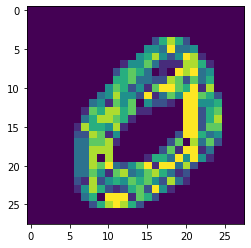

In [15]:
plt.imshow(torch.sum(pattern,dim=0).reshape(28,28))

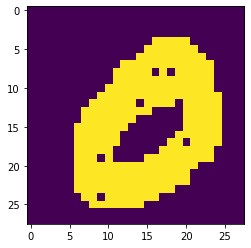

In [16]:
plt.imshow(torch.sum(out.squeeze(0),dim=0))

In [17]:
np.unique(torch.sum(out.squeeze(0),dim=0))

array([0., 8.], dtype=float32)

In [12]:
np.unique(torch.sum(pattern,dim=0).reshape(28,28))

array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32)

In [13]:
pattern

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
distance.hamming(out.reshape(784),(train_pattern[0]-4).reshape(784))

RuntimeError: shape '[784]' is invalid for input of size 6272

In [ ]:
distance.hamming(out.reshape(784),(pattern-4))

In [ ]:
out.squeeze(0).shape

In [ ]:
np.unique(MyColumn.ec.W)